<a href="https://colab.research.google.com/github/akshitachhabra2717/gdp-dashboard/blob/main/Copy_of_wheat_disease_pred_usiing_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import os
import numpy as np
import seaborn as sns
import pathlib
import PIL
from glob import glob
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Dropout,Conv2D, MaxPooling2D, GlobalAveragePooling2D,Input
from tensorflow.keras.applications import ResNet50, resnet50, Xception, xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if os.path.exists(data_dir):
    print(f"The directory '{data_dir}' exists.")
else:
    print(f"Error: The directory '{data_dir}' does not exist. Please update the path.")

The directory '/content/drive/MyDrive/wgd66f8n6h-1/wheat_leaf' exists.


In [ ]:
data_dir=("/content/drive/MyDrive/wgd66f8n6h-1/wheat_leaf")

In [ ]:
batch_size = 32
img_height = 200
img_width = 200


train_path = pathlib.Path(data_dir)
image_count = len(list(train_path.glob('*/*')))
print(image_count)

407


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="training",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

Found 407 files belonging to 3 classes.
Using 326 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)


Found 407 files belonging to 3 classes.
Using 81 files for validation.


In [ ]:
def plot_distribution(y, title):
    # Indent the code block within the function
    a = Counter(y)
    y = ['Healthy', 'Leaf_rust', 'Powdery_Mildew', 'Septoria_tritic_blotch','Strip_rust','Tanspot' ]
    x = [a[i] for i in range(6)]
    plt.figure(figsize=(8, 3))
    plt.barh(y, x, color='Green')
    plt.title(title)
    return plt.show()





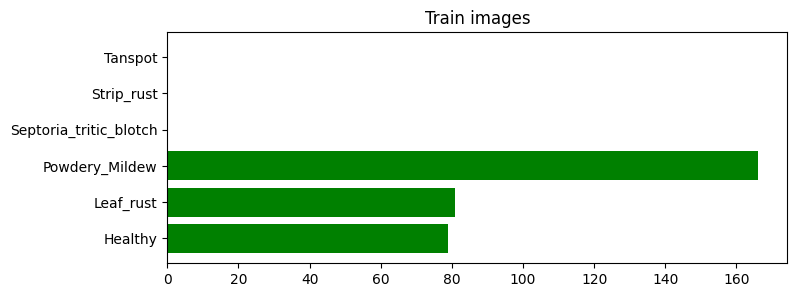

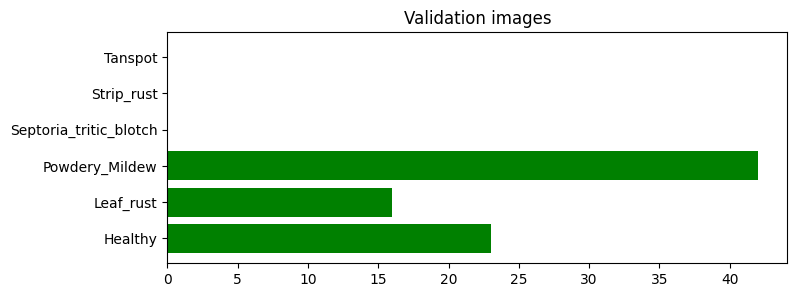

In [ ]:
# Target distribution
y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)
plot_distribution(y_train, title="Train images")
plot_distribution(y_val, title = "Validation images")


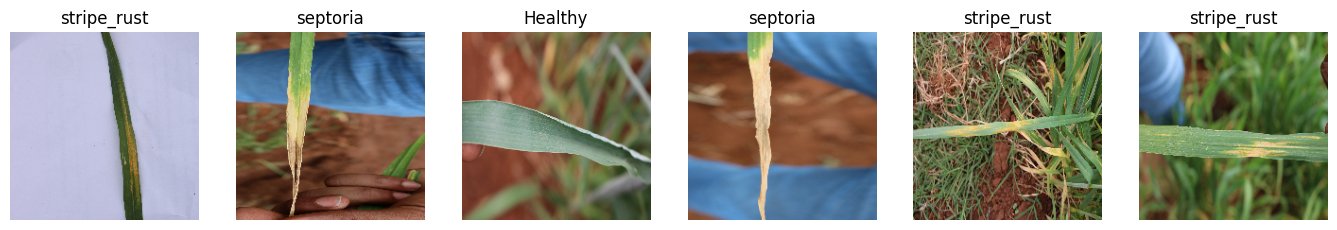

In [ ]:
## Sample images
class_names = train_ds.class_names
import matplotlib.pyplot as plt
plt.figure(figsize=(17, 17))
for images, labels in train_ds.take(1):
    # Indentation added here for the inner for loop
    for i in range(6):
        ax = plt.subplot(4, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
!pip install tensorflow --upgrade

In [ ]:
!pip install tensorflow --upgrade
import tensorflow as tf

# Model architecture
num_classes = 6
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Rescaling(1./255),  # Changed from tf.keras.layers.experimental.preprocessing.Rescaling to tf.keras.layers.Rescaling
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.summary()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet import ResNet50
# Defining the pretrained base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape =(200,200,3))
base_model.trainable=False
input_img=Input(shape=(200,200,3),name='input_image')
resnet=base_model(input_img,training=False)
resnet=GlobalAveragePooling2D()(resnet)
resnet=Dense(6,activation='softmax',name='classif_layer')(resnet)
resnet=Dropout(rate=0.2,name='drop_out')(resnet)
resnet_model=Model(inputs=input_img,outputs=resnet,name='WLD_Prediction_Model')
resnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 198, 198, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 99, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 97, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 33856)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,333,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,358,054 (16.62 MB)

 Trainable params: 4,358,054 (16.62 MB)

 Non-trainable params: 0 (0.00 B)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "WLD_Prediction_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classif_layer (Dense)                │ (None, 6)                   │          12,294 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop_out (Dropout)                   │ (None, 6)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
base_learning_rate = 0.001
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
base_learning_rate = 0.001
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
min_delta=0.0001,
patience=0)
history = resnet_model.fit(train_ds,
validation_data=val_ds,
epochs=20,
# callbacks=[earlystop_callback]
                           )

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
min_delta=0.0001,
patience=0)
history = resnet_model.fit(train_ds,
validation_data=val_ds,
epochs=20,
# callbacks=[earlystop_callback]
                           )


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 136s 11s/step - accuracy: 0.4113 - loss: 4.3933 - val_accuracy: 0.6914 - val_loss: 0.6955
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.6511 - loss: 3.3385 - val_accuracy: 0.8395 - val_loss: 0.3830
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.7374 - loss: 2.6941 - val_accuracy: 0.8765 - val_loss: 0.3320
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.7220 - loss: 2.4950 - val_accuracy: 0.8889 - val_loss: 0.2932
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.7118 - loss: 2.5968 - val_accuracy: 0.8642 - val_loss: 0.3296
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.7544 - loss: 2.3479 - val_accuracy: 0.9136 - val_loss: 0.3058
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 96s 7s/step - accuracy: 0.7529 - loss: 1.8270 - val_accuracy: 0.9136 - val_loss: 0.2909
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - accuracy: 0.7230 - loss: 1.8070 - val_accuracy: 0.9383 - val_los

In [ ]:
loss, acc = resnet_model.evaluate(val_ds, batch_size=batch_size)
print("validation accuracy :", round(acc, 2))
print("validation loss :", round(loss,2))

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.8976 - loss: 0.3885
validation accuracy : 0.89
validation loss : 0.45


In [ ]:
loss, acc = resnet_model.evaluate(train_ds, batch_size=batch_size)
print("Train accuracy :", round(acc, 2))
print("Train loss :", round(loss,2))

11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.9772 - loss: 0.0620
Train accuracy : 0.98
Train loss : 0.05


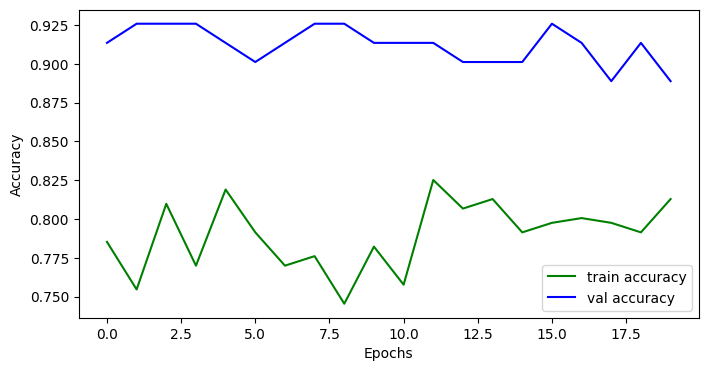

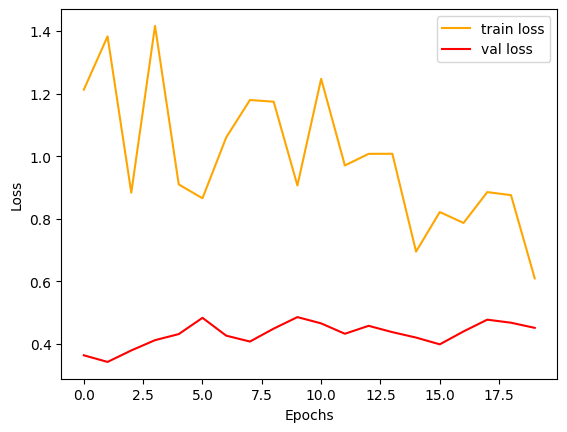

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']
# Accuracy plots
plt.figure(figsize=(8, 4))
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = [] # store predicted labels
y_true = [] # store true labels
# iterate over the dataset
for image_batch, label_batch in val_ds: # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = resnet_model.predict(image_batch)

    # append predicted labels
    y_pred.append(np.argmax(preds, axis = - 1))
# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


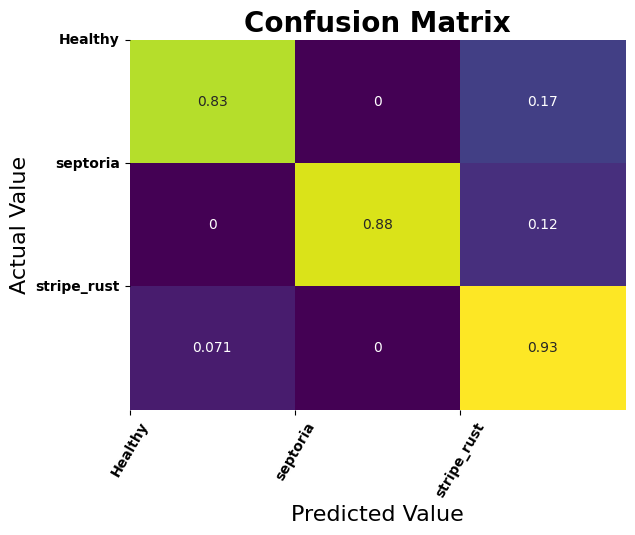

In [ ]:
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=60,fontsize=10,fontweight='bold')
plt.yticks(tick_marks, class_names,fontsize=10,rotation=0,fontweight='bold')
plt.title("Confusion Matrix",fontsize=20, fontweight='bold')
plt.ylabel("Actual Value", fontsize=16)
plt.xlabel("Predicted Value", fontsize=16)
plt.show()

In [ ]:
print(classification_report(correct_labels, predicted_labels,target_names=class_names))

              precision    recall  f1-score   support

     Healthy       0.86      0.83      0.84        23
    septoria       1.00      0.88      0.93        16
 stripe_rust       0.87      0.93      0.90        42

    accuracy                           0.89        81
   macro avg       0.91      0.88      0.89        81
weighted avg       0.89      0.89      0.89        81



In [ ]:
# Defining the pretrained base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape =(200,200,3))
base_model.trainable=False
input_img=Input(shape=(200,200,3),name='input_image')
resnet=base_model(input_img,training=False)
resnet=GlobalAveragePooling2D()(resnet)
resnet=Dropout(rate=0.2,name='drop_out')(resnet)
resnet=Dense(6,activation='softmax',name='classif_layer')(resnet)
resnet_model=Model(inputs=input_img,outputs=resnet,name='WLD_Prediction_Model')
resnet_model.summary()

Model: "WLD_Prediction_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop_out (Dropout)                   │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classif_layer (Dense)                │ (None, 6)                   │          12,294 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
# Fine-tune from this layer onwards
fine_tune_at = 150
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False # Indent this line to be inside the loop
#resnet_model=Dropout(rate=0.2,name='drop_out')(resnet_model)
# Number of layers in the base model:  175
resnet_model.summary()

Number of layers in the base model:  175


Model: "WLD_Prediction_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop_out (Dropout)                   │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classif_layer (Dense)                │ (None, 6)                   │          12,294 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 10,002,438 (38.16 MB)

 Non-trainable params: 13,597,568 (51.87 MB)

In [ ]:
base_learning_rate = 0.0001
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
min_delta=0.0001,
#patience=5
)
history = resnet_model.fit(train_ds,
validation_data=val_ds,
epochs=20,
#callbacks=[earlystop_callback]
)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 95s 7s/step - accuracy: 0.2889 - loss: 1.9094 - val_accuracy: 0.7284 - val_loss: 0.8160
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 90s 8s/step - accuracy: 0.9876 - loss: 0.1379 - val_accuracy: 0.7531 - val_loss: 1.0189
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 131s 7s/step - accuracy: 1.0000 - loss: 0.0309 - val_accuracy: 0.8148 - val_loss: 0.8640
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 89s 8s/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 0.8148 - val_loss: 0.7660
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.8272 - val_loss: 0.7026
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 78s 7s/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.8519 - val_loss: 0.6617
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 78s 7s/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.8519 - val_loss: 0.6260
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 78s 7s/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.8642 - val_los

In [ ]:
score_val = resnet_model.evaluate(val_ds, verbose=1)
accuracy_val = 100*score_val[1]
print('Validate accuracy = %.4f%% ' % accuracy_val)

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9194 - loss: 0.3529
Validate accuracy = 90.1235% 


In [ ]:
score_train = resnet_model.evaluate(train_ds, verbose=1)
accuracy_train = 100*score_train[1]
print('Train accuracy = %.4f%% ' % accuracy_train)

11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 1.0000 - loss: 7.9585e-04
Train accuracy = 100.0000% 


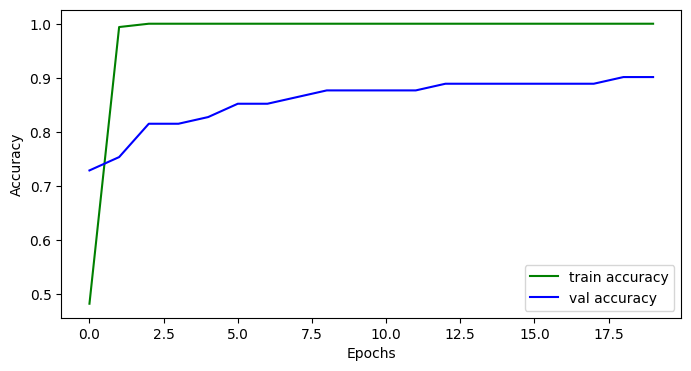

Text(0, 0.5, 'Loss')

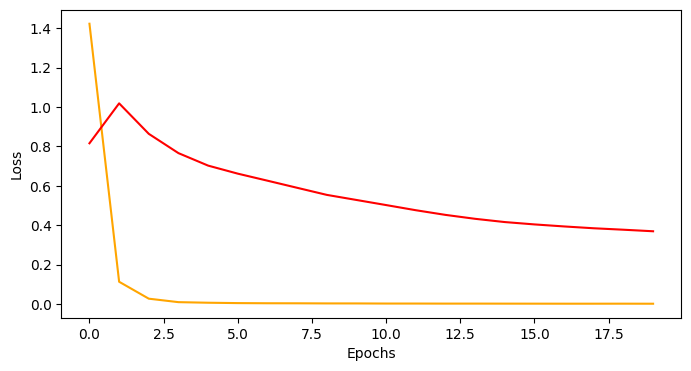

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']
# Accuracy plots
plt.figure(figsize=(8, 4))
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# loss plot
plt.figure(figsize=(8, 4))
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
y_pred = [] # store predicted labels
y_true = [] # store true labels
# iterate over the dataset
for image_batch, label_batch in val_ds: # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = resnet_model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis = - 1))
# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


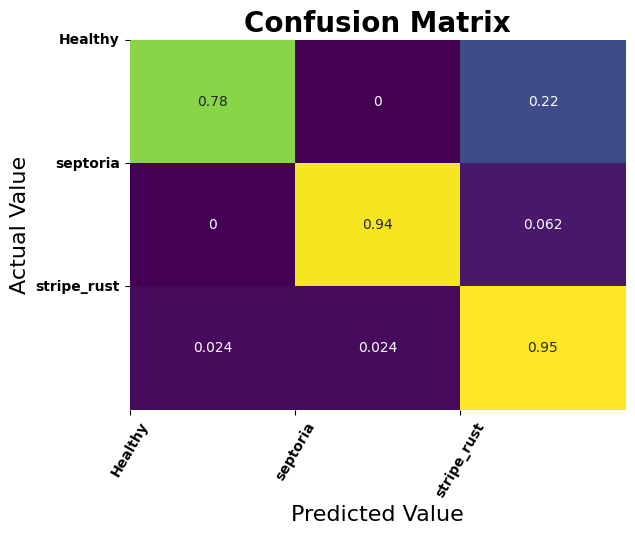

In [ ]:
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=60,fontsize=10,fontweight='bold')
plt.yticks(tick_marks, class_names,fontsize=10,rotation=0,fontweight='bold')
plt.title("Confusion Matrix",fontsize=20, fontweight='bold')
plt.ylabel("Actual Value", fontsize=16)
plt.xlabel("Predicted Value", fontsize=16)
plt.show()

In [ ]:
print(classification_report(correct_labels, predicted_labels,target_names=class_names))

              precision    recall  f1-score   support

     Healthy       0.95      0.78      0.86        23
    septoria       0.94      0.94      0.94        16
 stripe_rust       0.87      0.95      0.91        42

    accuracy                           0.90        81
   macro avg       0.92      0.89      0.90        81
weighted avg       0.91      0.90      0.90        81

